# Machine Learning


# Notebook set-up

In [297]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import io
import pickle
import statistics as stat
import statsmodels.api as sm
from statsmodels.api import OLS
import random
import statsmodels.formula.api as smf
import scipy as sp
from sklearn.metrics import classification_report
import scipy.stats
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from pandas.tools.plotting import scatter_matrix, radviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

sns.set_style('whitegrid')
sns.set_context('notebook')

# Data loading

In [218]:
# Load the data into a dataframe 
#can_master = pd.read_csv('can-1996-2016.csv')
#cmte_master =pd.read_csv('cm-1996-2014.csv') 
#opex=pd.read_csv('opex-2004-2014.csv')
#oth=pd.read_csv('oth-1996-2014.csv')
#exp=pd.read_csv('expresults_rev.csv')
#election_spend=pd.read_csv('catall.csv')
#results = pd.read_csv('candr.csv')
#catsort= pd.read_csv('catsort_rev.csv')
cost_vote = pd.read_csv('combined_all.csv')

In [219]:
cost_vote['total_votes']=cost_vote['total_votes'].fillna(0)
cost_vote['totalspend']=cost_vote['totalspend'].fillna(0)
cost_vote['incumbent']=cost_vote['incumbent'].fillna(0)
cost_vote['party']=cost_vote['party'].fillna('None')
cost_vote = cost_vote.drop(['costpervote'], axis=1)
cost_vote['totalspend']=pd.to_numeric(cost_vote['totalspend'],errors='coerce')
print(cost_vote[pd.to_numeric(cost_vote['totalspend'], errors = 'coerce').isnull()])
cost_vote['total_votes']=pd.to_numeric(cost_vote['total_votes'],errors='coerce')
print(cost_vote[pd.to_numeric(cost_vote['total_votes'], errors = 'coerce').isnull()])
cost_vote['cycle']=pd.to_numeric(cost_vote['cycle'],errors='coerce')
print(cost_vote[pd.to_numeric(cost_vote['cycle'], errors = 'coerce').isnull()])
cost_vote = cost_vote[cost_vote.total_votes != 0]
cost_vote.loc[cost_vote['totalspend'] == 0]
cost_vote = cost_vote.rename(columns = {'ge_winner_indicator':'winner'})
cost_vote['costvote'] = cost_vote['totalspend']/cost_vote['total_votes']
cost_vote['cycle'] = cost_vote['cycle'].astype(int).astype('str')
cost_vote['party'] = cost_vote['party'].astype('str')
cost_vote = cost_vote.replace("DEM","D")
cost_vote = cost_vote.replace("DEM ","D")
cost_vote = cost_vote.replace("REP","R")
cost_vote = cost_vote.replace("REP ","R")
Republican = cost_vote[cost_vote['party'] == "R"]
Democrat = cost_vote[cost_vote['party'] == "D"]

Empty DataFrame
Columns: [cand_id, cycle, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, state_abbreviation, district, incumbent, party, primary_votes, runoff_votes, general_votes, ge_runoff_election_votes, ge_winner_indicator, total_votes, totalspend]
Index: []

[0 rows x 26 columns]
Empty DataFrame
Columns: [cand_id, cycle, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, state_abbreviation, district, incumbent, party, primary_votes, runoff_votes, general_votes, ge_runoff_election_votes, ge_winner_indicator, total_votes, totalspend]
Index: []

[0 rows x 26 columns]
Empty DataFrame
Columns: [cand_id, cycle, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, state_abbreviation, district, incumbent, party, primary_votes, runoff_votes, general_votes, ge_runoff_election_votes, ge_winner_indicator, total_votes, totalspend]
Index: []

[0 rows x 26 columns]


In [220]:
testframes = [Republican, Democrat]
result = pd.concat(testframes)
Gen = result

In [221]:
Gen = Gen.replace("W (Runoff)","0")
Gen = Gen.replace("WW","0")
Gen = Gen.replace("Dd","0")

In [222]:
Gen['race'] = Gen['cand_id'].astype(str).str[0]

In [223]:
Gen = Gen[Gen['race'] == "H"]

In [224]:
#All winners of election
Winner = Gen[Gen['winner'].isin(['1'])]

In [225]:
#All losers of election
Loser = Gen[Gen['winner'].isin(['0'])]

In [226]:
Dem = Gen[Gen['party'].isin(['D'])]

In [227]:
#All Democrat Winners
DemW = Dem[Dem['winner'].isin(['1'])] 

In [228]:
#All democrat incumbent winners
DemWInc = DemW[DemW['incumbent'].isin(['1'])] #table of Democrat Incumbent who won

In [229]:
#All democrat challengesr who won
DemWC = DemW[DemW['incumbent'].isin(['0'])] 

In [230]:
DemL = Dem[Dem['winner'].isin(['0'])] #table of Democrats who lost

In [231]:
DemLInc = DemL[DemL['incumbent'].isin(['1'])] #table of Democrat Incumbent who lost

In [232]:
DemLC = DemL[DemL['incumbent'].isin(['0'])] #table of Democrat challengers who lost

In [233]:
Rep = Gen[Gen['party'].isin(['R'])] #republicans

In [234]:
#all republican winners
RepW = Rep[Rep['winner'].isin(['1'])]

In [235]:
#all republican incumbents
RepWInc = RepW[RepW['incumbent'].isin(['1'])]

In [236]:
#all republican challengers
RepWC = Rep[Rep['incumbent'].isin(['0'])]

In [237]:
#all republican losers
RepL = Rep[Rep['winner'].isin(['0'])]

In [238]:
#all republican incumbent who lost
RepLInc = RepL[RepL['incumbent'].isin(['1'])]

In [239]:
#all republican challengers who lost
RepLC = RepL[RepL['incumbent'].isin(['0'])]

# machine learning test

In [240]:
#define features
feature_cols = ['c1', 'c2','c3', 'c4','c5','c6','c7','c8','c9','c10','c11','c12','c13']

# Features of Republican Winners
X = RepW[feature_cols]

In [241]:
print (type(X))
print (X.shape)

<class 'pandas.core.frame.DataFrame'>
(1274, 13)


In [242]:
# defining the dependent
y = RepW['total_votes']

In [243]:
print (type(y))
print (y.shape)

<class 'pandas.core.series.Series'>
(1274,)


In [244]:
#checking X and y shapes
X.shape, y.shape

((1274, 13), (1274,))

In [245]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.4, random_state = 0)

In [246]:
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0)

In [247]:
X_train.shape, y_train.shape

((764, 13), (764,))

In [248]:
X_test.shape, y_test.shape

((510, 13), (510,))

In [249]:
from sklearn.linear_model import LinearRegression

# Fit regression to diabetes dataset
model = LinearRegression()
model.fit(X, y)
print(model.fit(X, y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean Squared Error: 2842610828.606
Coefficient of Determination: 0.021


In [250]:
#Linear Regression
print('the Y intercept is :', model.intercept_)
print ('the coefficients  are :', model.coef_)

the Y intercept is : 192592.849281
the coefficients  are : [-0.0076124   0.04769269  0.0266773  -0.02211656  0.1205316  -0.0845729
 -0.0024327  -0.06930386  0.65005561  0.1374288  -0.05370102 -0.0959757
 -0.00306321]


In [251]:
for idx, feature_cols in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(feature_cols, model.coef_[idx]))

The coefficient for c1 is -0.007612400811283767
The coefficient for c2 is 0.04769269177332913
The coefficient for c3 is 0.02667729958629962
The coefficient for c4 is -0.022116555762729237
The coefficient for c5 is 0.1205315967530081
The coefficient for c6 is -0.08457290231576596
The coefficient for c7 is -0.002432695678954294
The coefficient for c8 is -0.06930385767598544
The coefficient for c9 is 0.6500556070247431
The coefficient for c10 is 0.13742880329293322
The coefficient for c11 is -0.053701024448267284
The coefficient for c12 is -0.09597569675293532
The coefficient for c13 is -0.0030632071221836643


In [252]:
for idx, feature_cols in enumerate(X_train.columns):
    print('the Y intercept is :', model.intercept_)

the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281
the Y intercept is : 192592.849281


In [253]:
expected  = X
predicted = y

# Evaluate fit of the model
model.score(X, y)

0.020797220837908248

In [254]:
from sklearn.linear_model import Perceptron

model = Perceptron()
model.fit(X, y)
print(model.fit(X, y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))
print(model.score(X, y))

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
Mean Squared Error: 8629038276.936
Coefficient of Determination: -1.972
0.00470957613815


In [255]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
model.fit(X, y)
print(model.fit(X, y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))
print(model.score(X, y))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean Squared Error: 2204547663.665
Coefficient of Determination: 0.241
0.240592775721


In [256]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X, y)
print(model.fit(X, y))

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Mean Squared Error: 16840777.555
Coefficient of Determination: 0.994


In [257]:
from sklearn.svm import SVR

model = SVR()
model.fit(X, y)
print(model.fit(X,y))
expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Mean Squared Error: 2906396678.748
Coefficient of Determination: -0.001


In [258]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor()
model.fit(X, y)
print(model.fit(X,y))
expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)
Mean Squared Error: 2671335837.471
Coefficient of Determination: 0.080


# Yellow Brick for Republicans

In [259]:
Rep.columns

Index(['cand_id', 'cycle', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', 'c10', 'c11', 'c12', 'c13', 'state_abbreviation', 'district',
       'incumbent', 'party', 'primary_votes', 'runoff_votes', 'general_votes',
       'ge_runoff_election_votes', 'winner', 'total_votes', 'totalspend',
       'costvote', 'race'],
      dtype='object')

In [260]:
features = Rep[[
   'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13'
]]

X = features

y = Rep['winner']

print(X.shape)
print(y.shape)

(4616, 13)
(4616,)


In [261]:
list(features)

['c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c9',
 'c10',
 'c11',
 'c12',
 'c13']

In [262]:
#Creating the test and train with sample size of 40%
from sklearn.model_selection import train_test_split as tts 
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25)

In [263]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3462, 13), (1154, 13), (3462,), (1154,))

             precision    recall  f1-score   support

          0       0.75      0.95      0.84       715
          1       0.66      0.22      0.32       293

avg / total       0.72      0.74      0.69      1008



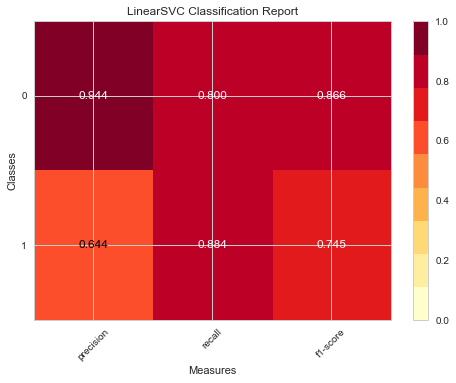

In [271]:
from sklearn.svm import LinearSVC

model = LinearSVC() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()             

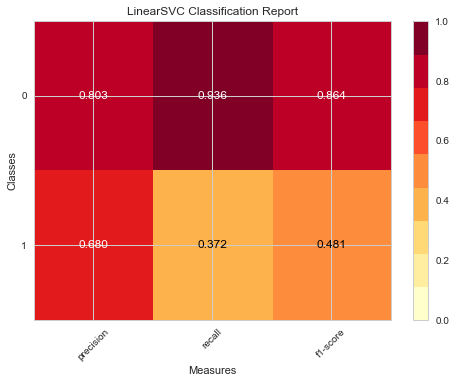

In [213]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

/Users/dave/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.73      1.00      0.85       845
          1       0.00      0.00      0.00       309

avg / total       0.54      0.73      0.62      1154



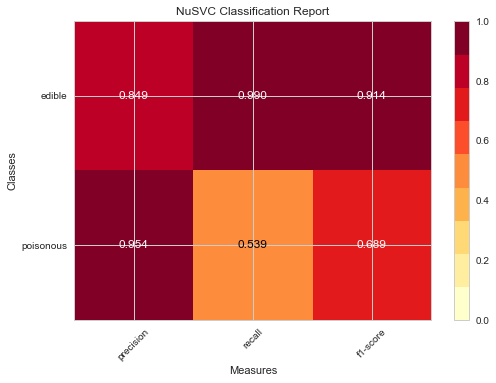

In [215]:
from sklearn.svm import NuSVC

model = NuSVC() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

visual_model_selection(X, y, NuSVC())

# Yellow Brick for Democrats

In [293]:
features = Dem[[
   'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13'
]]

X = features

y = Dem['winner']

print(X.shape)
print(y.shape)

(4029, 13)
(4029,)


In [294]:
from sklearn.model_selection import train_test_split as tts 
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25)

In [295]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3021, 13), (1008, 13), (3021,), (1008,))

             precision    recall  f1-score   support

          0       0.77      0.96      0.85       719
          1       0.74      0.27      0.39       289

avg / total       0.76      0.76      0.72      1008



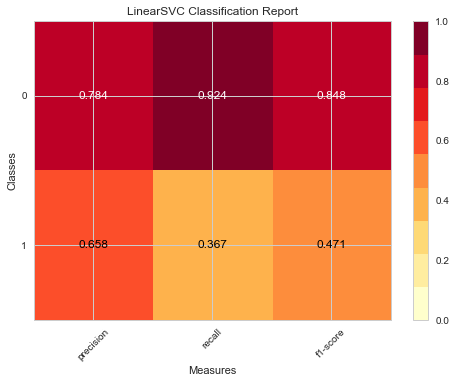

In [296]:
from sklearn.svm import LinearSVC

model = LinearSVC() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof() 

# Modeling and Evaluation

In [132]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        
        return output

In [133]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline


def model_selection(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())), 
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted))

In [134]:
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [135]:
model_selection(X, y, LinearSVC())

0.9940875049270792

In [136]:
model_selection(X, y, NuSVC())

0.68906720160481449

In [137]:
model_selection(X, y, SVC())

/Users/dave/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [138]:
model_selection(X, y, SGDClassifier())

0.91059841384282636

In [139]:
model_selection(X, y, KNeighborsClassifier())

0.67791032496914849

In [140]:
model_selection(X, y, LogisticRegressionCV())

0.11005135730007336

In [141]:
model_selection(X, y, LogisticRegression())

0.97809637594583831

In [142]:
model_selection(X, y, BaggingClassifier())

0.89430894308943087

In [143]:
model_selection(X, y, ExtraTreesClassifier())

0.9940781681800237

In [144]:
model_selection(X, y, RandomForestClassifier())

0.91898734177215191

# Regularization by Winning Indicator


In [266]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.1)
model.fit(X, y)

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

Mean Squared Error: 0.150
Coefficient of Determination: 0.249


In [267]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1)
model.fit(X, y)

expected  = y
predicted = model.predict(X)

# Evaluate fit of the model
print("Mean Squared Error: %0.3f" % mse(expected, predicted))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

Mean Squared Error: 0.150
Coefficient of Determination: 0.249
